<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW1/hw1_problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW1. Problem 3. 


   - Load the training and test data using Keras, no validation set needed.
   - Create network with an input layer consisting of 28 x 28 input neurons and an output layer consisting of 10 output neurons.
   - Use softmax and categorical cross entropy loss.
   - Implement mini-batch stochastic gradient descent using only numpy, that is, you are not allowed to use TensorFlow/Keras for SGD.




##Comments
* The majority of the code is reusued from problems 2 and 4.
* Code for loading and preparing of the data is reused from `mnist_digits_classification_dense_layers.ipynb`
* Some other code is reused from `linear_regression_gradient_descent.ipynb`

## Loading the image data

In [0]:
import numpy as np
from keras.datasets import mnist

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

# shape parameters
m = 60000
m_test = 10000

## Preparing the image data

In [0]:
train_images = train_images_original.reshape((m, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((m_test, 28 * 28))
test_images = test_images.astype('float32') / 255

## Preparing the labels

We need to categorically encode the labels.

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels_original)
test_labels = to_categorical(test_labels_original)

## Adding biases


In [0]:
X_b = np.c_[np.ones((m,1)), train_images]
tstX_b = np.c_[np.ones((m_test,1)), test_images]

## Display prepared data

In [56]:
print(X_b[0:2])
# print(X_b[3])
print(X_b.shape)
print(X_b.shape[1])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(60000, 785)
785


## Defining different helper functions unrelated to ML

In [0]:
from IPython.display import HTML, display
import time

# https://stackoverflow.com/questions/46939393/how-do-i-use-updatable-displays-on-colab
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 80%'
        >
            {value}
        </progress>
        <p>{value} of {max} complete</p>
    """.format(value=value, max=max))

## Defining model

In [0]:
initial_weights = np.random.randn(X_b.shape[1],10)
weights=initial_weights
learning_rate = 0.1
batch_size = 128

In [0]:
def softmax(z):
  # stabilizing according to https://www.deeplearningbook.org/contents/numerical.html
  z = z - z.max(1, keepdims=True)
  exps = np.exp(z)
  return exps / exps.sum(1, keepdims=True)

def logSoftmax(z):
  # needed for stabilizing according to https://www.deeplearningbook.org/contents/numerical.html
  z = z - z.max(1, keepdims=True)
  exps = np.exp(z)
  return z - np.log(exps.sum(1, keepdims=True))

In [0]:
def Loss(X, y, W):
  z = X.dot(W)
  return -(logSoftmax(z)*y).sum() / y.shape[0]  

Because ${\frac {\partial \mathcal L} {\partial z_j}} = \sum_{k=1}^my_k(a_j-\delta_{jk}) = (a_j\sum_{k=1}^my_k) - y_j$ ...

In [0]:
def gradLoss(X, y, W):
  a = softmax(X.dot(W))
  return X.T.dot(a*y.sum(1, keepdims=True) - y) / y.shape[0]
  

In [0]:
def calcAccuracy(real, predicted):
  r = real.argmax(1)
  p = predicted.argmax(1)
  return (r == p).sum()/r.shape
   
def Acc(X, y, W): return calcAccuracy(y, X.dot(W))

In [0]:
# returns new weights
def one_epoch(X, W, y, batch_size):
  m=X.shape[0]
  shuffled_indices = np.random.permutation(m)
  Xs = X[shuffled_indices]
  ys = y[shuffled_indices]
  Wi=W
  for i in range(0, m, batch_size):
    Xi = Xs[i:i+batch_size]
    yi = ys[i:i+batch_size]
    gradient = gradLoss(Xi, yi, Wi)
    Wi = Wi - learning_rate * gradient
  return Wi


def init_model():
  global weights
  global loss_values
  global tst_loss_values
  global tr_acc
  global tst_acc
  weights = initial_weights
  loss_values=[]
  tst_loss_values=[]
  tr_acc=[]
  tst_acc=[]

def train(epoches):
  global weights
  pr_bar = display(progress(0, epoches), display_id=True)
  for epoch in range(epoches):
    weights = one_epoch(X_b, weights, train_labels, batch_size)
    loss_values.append(Loss(X_b, train_labels, weights))
    tst_loss_values.append(Loss(tstX_b, test_labels, weights))
    tr_acc.append(Acc(X_b, train_labels, weights))
    tst_acc.append(Acc(tstX_b, test_labels, weights))
    pr_bar.update(progress(epoch+1, epoches))
  

## The training step

In [64]:
epochs = 50
init_model()
train(epochs)
# print(loss_values)

## Display the training/test loss/accuracy

In [0]:
epochs_range = range(1, epochs + 1)

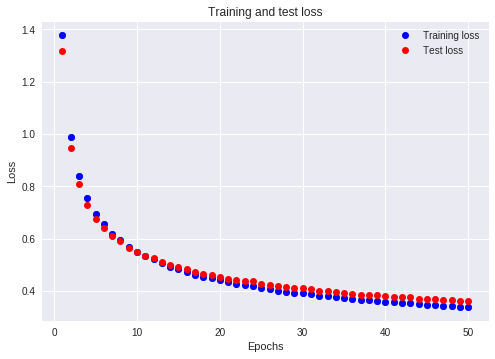

In [66]:
import matplotlib.pyplot as plt

plt.plot(epochs_range, loss_values, 'o')

plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, tst_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

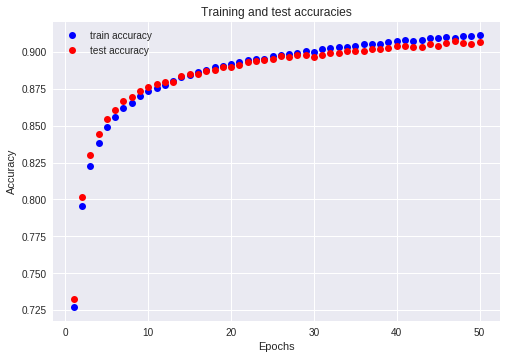

In [67]:
plt.plot(epochs_range, tr_acc, 'bo', label="train accuracy")
plt.plot(epochs_range, tst_acc, 'ro', label="test accuracy")


plt.title('Training and test accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# print(tr_acc)
# print(tst_acc)

## Exploring results

In [68]:
predicted_labels = np.argmax(tstX_b.dot(weights), axis=1) 
predicted_labels = predicted_labels.astype('uint8')
wrong_indices = [i for i in range(10000) if predicted_labels[i] != test_labels_original[i]]
good_indices = [i for i in range(10000) if predicted_labels[i] == test_labels_original[i]]
1.0 - len(wrong_indices) / 10000.0

0.9067000000000001

4 is classified as 5


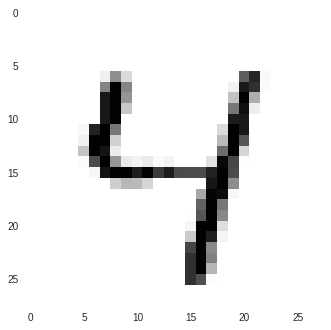

In [69]:
# This show the ith misclassified digit. 
i = 9
wrong_index = wrong_indices[i]  
print(test_labels_original[wrong_index], 'is classified as', predicted_labels[wrong_index])
plt.imshow(test_images_original[wrong_index])
plt.grid(None)
plt.show()

8 is classified as 8


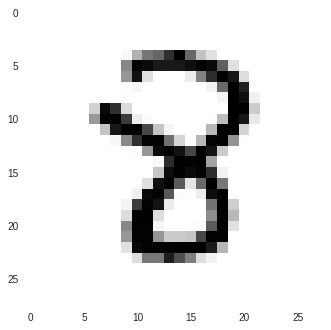

In [70]:
# This show the ith correctly classified digit. 
i = 999
index = good_indices[i]  
print(test_labels_original[index], 'is classified as', predicted_labels[index])
plt.imshow(test_images_original[index])
plt.grid(None)
plt.show()